---
title: NeuralODE - Neural Ordinary Differential Equations
subtitle: Theory to Practice - A Tutorial on NeuralODE representation.
date: 2025-10-16
bibliography:
  - references.bib
---

Neural Ordinary Differential Equations (NeuralODE) is a continuous normalizing flow model proposed
by [@chen2018neural]. It works by evolving ordinary differential equations according to neural
network defined functions. Since, ODEs under mild conditions are diffeomorphic as described by the
Picard-Lindelof theorem, it means that NeuralODEs are invertible transformations. Therefore, they
provide a way of representing only non-self-intersecting geometry.In this tutorial, we walk through
the theory behind the NeuralODE representation and how to actually use their `geodiff`
implementation in practice.

In [1]:
# Basic Imports
import matplotlib.pyplot as plt
import torch

from geodiff.neural_ode import NeuralODE
from geodiff.loss_functions.chamfer import ChamferLoss
from geodiff.template_architectures import ResMLP

from assets.utils import square, normalize_0_to_1

## Theoretical Background
The Neural Ordinary Differential Equation (NeuralODE) architecture as proposed in [@chen2018neural]
is based on the idea of parameterizing a continuous-time dynamical system using a neural network.
Rather than composing a finite sequence of discrete invertible transformations (as in NICE or
RealNVP), a Neural ODE models a continuously invertible transformation obtained by integrating a
learned vector field over time.

Formally, given an input $\mathbf{x}_0 \in \mathbb{R}^D$, the Neural ODE defines a
time-dependent transformation
$\mathbf{f}_{\theta}: \mathbb{R}^D \times [0, 1] \rightarrow \mathbb{R}^D$ through an ordinary
differential equation (ODE):
:::{math}
:label: neural_ode_definition
\frac{d\mathbf{x}(t)}{dt} = f_\theta(\mathbf{x}(t), t),
\quad
\mathbf{x}(0) = \mathbf{x}_0,
:::
where $f_{\theta}$ is a neural network with parameters $\theta$ that outputs a velocity (or rate of
change) at each point $\mathbf{x}(t)$ and time $t$. Integrating this ODE from $t = 0$ to $t = 1$
yields the overall mapping:
:::{math}
:label: neural_ode_integration
\mathbf{x}(1) = \mathbf{x}_0 + \int_{0}^{1} f_\theta(\mathbf{x}(t), t) dt
:::
Hence, the Neural ODE defines a transformation $\Phi_\theta : \mathbf{x}_0 \mapsto \mathbf{x}(1)$
that is implicitly determined by a continuous flow.

For representing non-self-intersecting geometry we want invertible transformations. For Neural ODEs,
this property arises naturally from the theory of ordinary differential equations, and can be
formally guaranteed by the **Picard–Lindelöf theorem** (also known as the
**Cauchy–Lipschitz theorem** or the **existence and uniqueness theorem**).

The theorem states that if the vector field
$f_\theta(\mathbf{x}, t)$ is Lipschitz continuous in $\mathbf{x}$ and continuous in $t$, then for every initial condition $\mathbf{x}_0$, there exists a unique differentiable solution $\mathbf{x}(t)$ to the ODE defined by Eq.
[](#neural_ode_definition). This guarantee implies that the flow generated by integrating $f_\theta$
forward in time is bijective and continuously invertible: each point $\mathbf{x}_0$ follows a unique
trajectory through state space, and no two trajectories can intersect. Consequently, the mapping
defined by the flow at time $t = 1$,
:::{math}
:label: diffeomorphic_transformation
\Phi_\theta(\mathbf{x}_0) = \mathbf{x}(1),
:::
is a diffeomorphism - a smooth, invertible transformation with a smooth inverse given by integrating
the same ODE backward in time.

In the context of geometry representation, we interpret $\mathbf{x}(t)$ as the evolving coordinates
of points on a baseline closed manifold (for example, a unit circle or sphere). The ODE defines how
these baseline points flow through a neural velocity field $f_\theta(\mathbf{x}, t)$ to form the
final geometry at $t = 1$:
:::{math}
:label: neural_ode_geometry
\mathbf{X}(t) =
\mathbf{X}(0) + \int_{0}^{t} f_\theta(\mathbf{X}(\tau), \tau), d\tau
\qquad
\mathbf{X}(0) = \text{ClosedTransform}(T),
:::
where the parameter samples $T \in [0, 1]^{d-1}$ define coordinates on the input parameter domain.
The function $\mathrm{ClosedTransform}(T)$ maps these parameters to a closed baseline manifold - for
example, the unit circle in 2D or the unit sphere in 3D. Integrating the neural velocity field
$f_{\theta}$ from $t = 0$ to $t = 1$ then evolves this baseline into the final smooth and
non-self-intersecting geometry $\mathbf{X}(1)$.

## Implementation using `geodiff`
We now look at how `geodiff` allows us to easily use the NeuralODE parameterization to represent
shapes.

The NeuralODE class initializer and its expected arguments are shown below:
:::{literalinclude} ../src/geodiff/neural_ode.py
:start-at: __init__
:end-at: -> None
:::

To construct a NeuralODE object, we need to supply:
- **Geometry Dimension** 2 for 2D and 3 for 3D.
- **Coupling Net** a torch network module to be used as the function driving the ODE.

We use the `torchdiffeq` package created by [@chen14torchdiffeq] to implement NeuralODEs for
geometry representation.

### Fitting Shapes
We will use a square as our target geometry. We then use the `ChamferLoss` to compute the geometric
difference loss between the target shape and the shape represented by our NeuralODE
parameterization. Since the implementation is written in PyTorch we can use the autograd
capabilities to compute the gradients of the loss w.r.t. the NeuralODE network parameters and use an
optimizer to modify our geometry.

We start by obtaining points on our shapes and normalizing them appropriately such that
$x \in [0, 1]$. This is not needed for NeuralODE but is used to offer a comparison with the
classical shape representation methods like Hicks-Henne and CST.

In [2]:
# Get points on a square (curve to fit)
num_pts = 1000
X_square = square(num_pts)

# Normalize x values to the range [0, 1] to compare with other representation methods
X_square = normalize_0_to_1(X_square)

We now create a `NeuralODE` object by specifying the geometry dimension and a ODE function network.

In [3]:
# Create a NeuralODE object
# First create a torch ode network to pass to the NeuralODE initializer
geometry_dim = 2
ode_net = ResMLP(input_dim = geometry_dim + 1, output_dim = geometry_dim, layer_count = 2,
                 hidden_dim = 20, norm_f = torch.nn.LayerNorm, out_f = torch.nn.Tanh)
neural_ode = NeuralODE(
    geometry_dim = geometry_dim,
    ode_net = ode_net,
)

We use the `ChamferLoss` provided by `geodiff` to compute a geometric loss between the target shape
and the shape represented by the `NeuralODE` object. PyTorch's autograd capabilities then allow us
to compute gradients of the loss w.r.t. the NeuralODE network parameters and modify them to fit the
target shape.

In [4]:
# Train the NeuralODE parameters to fit the square
loss_fn = ChamferLoss()

learning_rate = 0.01
epochs = 1000
print_cost_every = 200

Y_train = X_square

optimizer = torch.optim.Adam(neural_ode.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.99)

for epoch in range(epochs):
    Y_model = neural_ode(num_pts = num_pts)
    
    loss = loss_fn(Y_model, Y_train)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(loss.item())

    if epoch == 0 or (epoch + 1) % print_cost_every == 0:
        num_digits = len(str(epochs))
        print(f'Epoch: [{epoch + 1:{num_digits}}/{epochs}]. Loss: {loss.item():11.6f}')

Epoch: [   1/1000]. Loss:    0.418259
Epoch: [ 200/1000]. Loss:    0.000310
Epoch: [ 400/1000]. Loss:    0.000142
Epoch: [ 600/1000]. Loss:    0.000079
Epoch: [ 800/1000]. Loss:    0.000055
Epoch: [1000/1000]. Loss:    0.000050


We can now visualize the shape represented by our `NeuralODE` object using its `visualize` method.

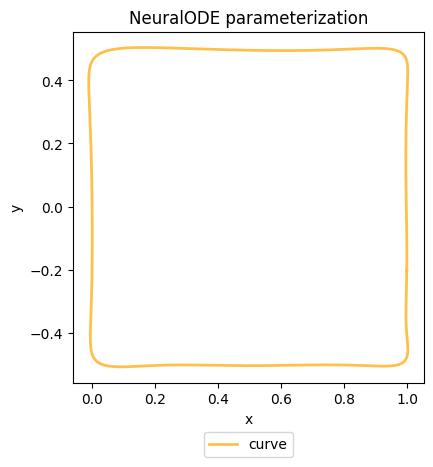

In [5]:
# Visualize the fitted NeuralODE shape
fig, ax = neural_ode.visualize(num_pts = num_pts)
plt.tight_layout()
plt.show()